# Identifying Stellar Spectrum Line Using Simple Methods, Maximum Likelihood Estimation, and MCMC  | Preet Patel

In [3]:
import numpy as np
import h5py
import scipy
import math
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import binom
from scipy.stats import poisson
from matplotlib import pyplot as plt
import random
import astropy.io.fits as fits
from scipy.stats import uniform
import seaborn as sn
import pandas as pd
from IPython.display import display, HTML
from astropy.cosmology import Planck15 as cosmo
from matplotlib.patches import Ellipse
from scipy import optimize

import itertools
import emcee
import corner

sigma = 0.5
amp_t = 1.5
lam_t = 5500
sig_t = 200
ndim, nwalkers = 3, 50
plt.rcParams["font.family"] = "Serif"
plt.rcParams.update({'font.size': 10, 'font.weight' : 100})

data_dir = "spectralline.txt"

data = np.loadtxt(data_dir, unpack = True)
wl = data[0]
amplitude = data[1]
wl, amp = np.loadtxt(data_dir, unpack = True)

def lnl(p, x, y, s):
    amp, sig, lam_0 = p
    m = amp*np.exp(-(x-lam_0)**2 / (2*sig**2))
    inv_s = 1./(s**2)
    return -np.sum((y - m)**2 *inv_s)

def pdf_gauss( x, mu, s ):
    return np.exp(-((x-mu)/s)**2/2)/(np.sqrt(2*np.pi)*s)

nll = lambda *args: -lnl(*args)
opt = minimize(nll, [amp_t, sig_t, lam_t], args = (data[0], data[1], 50))
amplitude, sigma_solved, lambda_solved = opt.x

# Raw Data and Initial Smoothing/Identification

I try a simple line-smooothing algorithms to decouple the noisiness of the data from the useful information. I want to find the line-width of our spectral line for potential use in determining characteristics of the host star. Based on the instrumentation used, I know that the instrumental linewidth is 20 angstroms. I want to find the linewidth of the spectral line itself.

To start, I'll using Gaussian kernel smoothing to find a peak and linewidth in the data. 

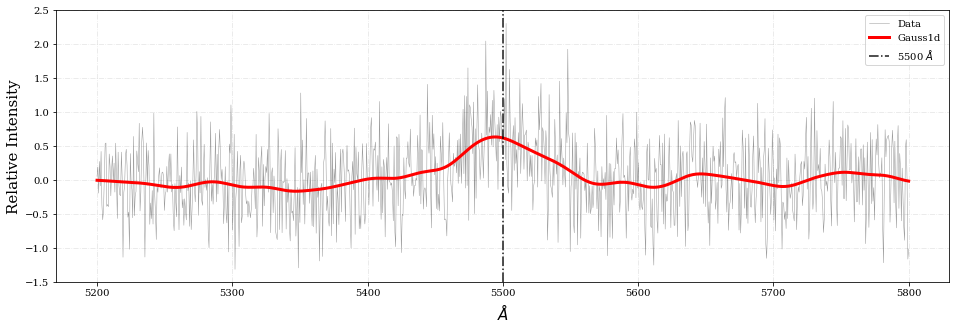

In [4]:
from astropy.convolution import Gaussian1DKernel, convolve
x = wl

# Create kernel
g = Gaussian1DKernel(stddev=20)
# Convolve data
z = convolve(data[1], g)

n = 20
plt.figure(figsize = (16,5))
plt.plot(data[0], data[1], 'k-', lw = 0.5, alpha = 0.4, label='Data')
#plt.plot(data[0][n:len(data[0])], moving_average(len(x), data[0], n), label = r"20 $\AA$ Moving Average", color = 'blue')
plt.plot(data[0], z, label='Gauss1d', lw = 3, color = 'red')
plt.axvline(5500, ls = "-.", color = "black", alpha = 0.9, label = r"5500 $\AA$")
plt.grid(ls = "-.", alpha = 0.3)
plt.xlabel(r"$\AA$", size = 15)
plt.ylabel("Relative Intensity", size = 15)
plt.ylim(-1.5,2.5)
plt.legend(loc='best')
plt.show()

### Central Moments

To get a grip on this data, I can now find the central moments of the distributions to estimate the mean and the variance, which will help us find the linewidth.

Probability theory defines the central moment of a univariate distribution as follows: 

$$\mu_n = E[(X - E[X]^n)] = \int_{-\infty}^{\infty}(x - \mu)^n f(x) dx$$

where $f(x)$ is continuous. 

$$\mu_0 = 1$$

$$\mu_1 = \mu \ \text{(average)}$$

$$\mu_2 = \sigma^2 \ \text{(variance)}$$

$$\mu_3 = \gamma \ \text{(skewness)}$$

$$\mu_4 = \kappa \ \text{(kurtosis)}$$

We can find the peak from the mean and the line width from the variance, so long as we evaluate the moment in the correct interval:

In [5]:
first = np.sum(data[0]*data[1])/np.sum(data[1])
second = np.sum((data-first)**2 * data[1])/(np.sum(data[1]))
index_oi = int(np.median(np.where((data[0] > 5499) & (data[0] < 5501))[0]))
print("Index for 5500 Angstroms: " + str(index_oi) + "\n")

def mom1(x,y, index, boxsize):
    lower = int(np.median(np.where((x > x[index]-boxsize-1) & (x < x[index]-boxsize+1))[0]))
    upper = int(np.median(np.where((x < x[index]+boxsize+1) & (x > x[index]+boxsize-1))[0]))
    mom1 = np.sum(x[lower:upper]*y[lower:upper])/np.sum(y[lower:upper])
    return np.abs(mom1)

def mom2(x,y, index, boxsize):
    firstmom = mom1(x,y,index,boxsize)
    lower = int(np.median(np.where((x > x[index]-boxsize-1) & (x < x[index]-boxsize+1))[0]))
    upper = int(np.median(np.where((x < x[index]+boxsize+1) & (x > x[index]+boxsize-1))[0]))

    xdiff = x[lower:upper]-firstmom
    sig2 = np.sum((xdiff**2)*y[lower:upper])/np.sum(y[lower:upper])
    
    return np.sqrt((sig2))

print("First Moments")
print("Box - 80:  " + str(mom1(data[0], data[1], index = index_oi, boxsize = 80)))
print("Box - 100: " + str(mom1(data[0], data[1], index = index_oi, boxsize = 100)))
print("Box - 120: " + str(mom1(data[0], data[1], index = index_oi, boxsize = 120)))
print("\nSecond Moments")
print("Box - 80:  " + str(mom2(data[0], data[1], index = index_oi, boxsize = 80)))
print("Box - 100: " + str(mom2(data[0], data[1], index = index_oi, boxsize = 100)))
print("Box - 120: " + str(mom2(data[0], data[1], index = index_oi, boxsize = 120)))

Index for 5500 Angstroms: 500

First Moments
Box - 80:  5494.039995532123
Box - 100: 5493.150664679368
Box - 120: 5486.049159431318

Second Moments
Box - 80:  17.282371763465008
Box - 100: 29.824967410274215
Box - 120: nan


<ipython-input-5-2ef7715f9dc7>:20: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((sig2))


### Is this a reliable procedure?
<b>The stability is quite low</b> for this procedure, given how much the first and second moments change.

I see that our expected value (first moment) drifts slightly to the left as we increase our boxsize. This might be due to the frequency of relatively large intensity values being higher to the left of the peak than to the right (as seen in the Gaussian smoothing, in red). This has an effect on the Second moments as well, where the increasing boxsize makes the width larger. In the case of the largest width bin, asymmetries above and below zero lead to an invalid result.

### What could we do better?
We would need to deconvolute the sigmas here. Assuming Gaussian profiles, I would take the true linewidth as being the sum of the observed and instrumental linewidths. i.e.

$$\sigma_{obs} = \sqrt{\sigma_{true}^2 + \sigma_{inst}^2}$$

I would use the true linewidth and subtract the observed to get the instrumental linewidth, which I would ultimately be able to subtract from my observed. 

<b>The stability of this procedure is also quite low</b>. Like when $\sigma_{true}^2$ is not large with respect to $\sigma_{inst}^2$, and thus contributes little to the $\sigma_{obs}$, or vice versa. 


# Finding a linewidth with forward modeling

The procedure above is admittedly lacking in its explanatory power, even if we visually may agree with the results. To get a more robust result, we can model the gaussian that should comprise our spectral line and use its width to better constrain the linewidth itself. We also know that the instrumental linewidth (or 'error') is about 20 angstroms. 


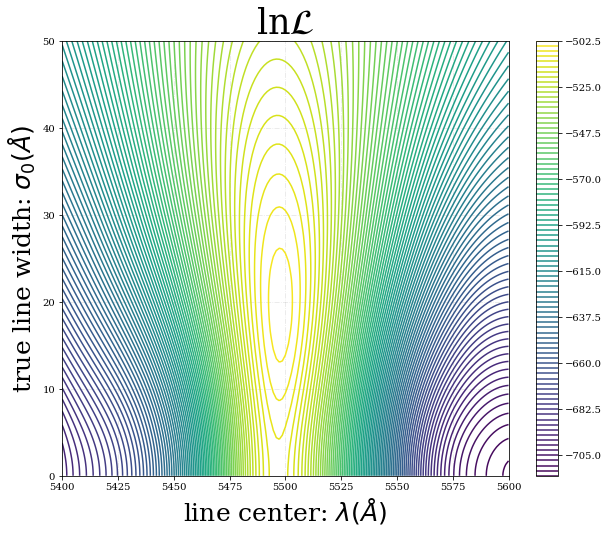

In [29]:
data = np.loadtxt(data_dir)
lamb = data[:,0]
intensity = data[:,1]
A = 50
sig_data = 0.5
sig_instr = 20

def model(A, x, lamb0, sig_true):
    sig_obs = np.sqrt(sig_true**2 + sig_instr**2)
    normed = A/np.sqrt(2*np.pi*(sig_true**2 + sig_instr**2))
    gauss = normed*np.exp(-0.5*((x-lamb0)**2 / sig_obs**2))
    return gauss

nsig = 150
nlam = nsig-1
sigs = np.linspace(0,50,nsig)
lambs = np.linspace(5400, 5600, nlam)
lnL = np.zeros([nsig,nlam])

#sorry for not passing this in a function, kept getting errors and needed to break it down
for i, l0 in enumerate(lambs):
    for j, s0 in enumerate(sigs):
        lnl = -0.5*(intensity - model(50, lamb, l0, s0))**2 / (sig_data**2)
        lnL[j,i] = lnl.sum()
        
plt.figure(figsize = (10,8))        
X,Y = np.meshgrid(lambs, sigs)
plt.contour(X,Y,lnL, 100)
plt.colorbar()
plt.grid(ls = "-.", alpha = 0.3)
plt.title(r"ln$\mathcal{L}$", size = 35)
plt.xlabel(r"line center: $\lambda (\AA)$", size = 25)
plt.ylabel(r"true line width: $\sigma_0 (\AA)$", size = 25)

plt.show()

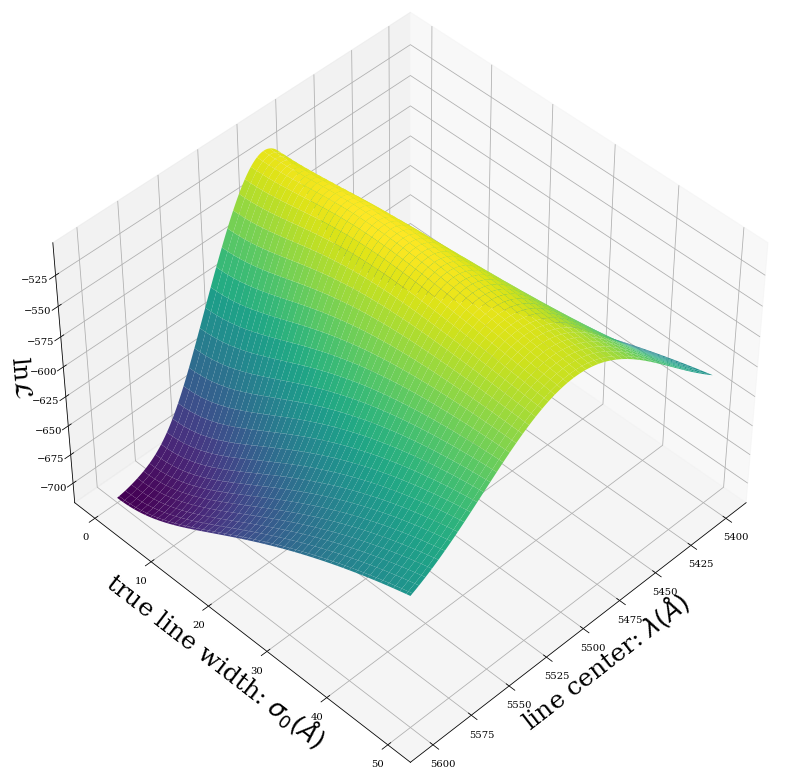

In [102]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize = (14,14))
ax = fig.add_subplot(111, projection="3d", azim = 45, elev = 45)
ax.plot_surface(X,Y,lnL, cmap="viridis", lw=0)
ax.set_zlabel(r"ln$\mathcal{L}$", size = 25)
ax.set_xlabel(r"line center: $\lambda (\AA)$", size = 25)
ax.set_ylabel(r"true line width: $\sigma_0 (\AA)$", size = 25)
plt.show()

### 68, 95, and 99th percentile regions 

We can use the relationship between $\chi^2$ and the log-likelihood to estimate a highest-likelihood region containing our values

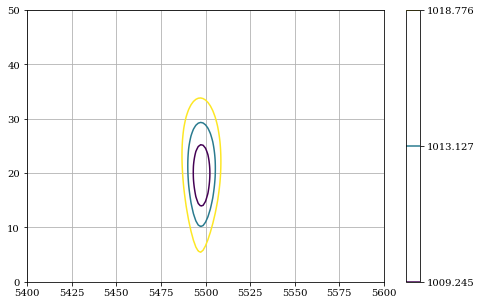

In [145]:
chisq = -2*lnL

levels = chisq.min()+ np.array([2.2977,6.1801,11.829]) #68, 95, and 99 percentile regions 

plt.figure(figsize = (8,5))
#ind = np.argmax(lnL)
#mm,jj = np.unravel_index(ind, lnL.shape)
#logL_max = lnL[mm][jj]
#print(np.average(X[mm]),np.average(Y[jj]))

lnl_wavelength_solved = X[np.where(chisq == np.min(chisq))]
lnl_sigma_solved = Y[np.where(chisq == np.min(chisq))]

plt.contour(X,Y,chisq, levels)
plt.colorbar()
plt.grid()
plt.show()

In [108]:
def lnl(p, x, y, s):
    amp, sig, lam_0 = p
    m = amp*np.exp(-(x-lam_0)**2 / (2*sig**2))
    inv_s = 1./(s**2)
    return -np.sum((y - m)**2 *inv_s)

nll = lambda *args: -lnl(*args)
opt = minimize(nll, [amp_t, sig_t, lam_t], args = (wl,amp,sigma))
amplitude, sigma_solved, lambda_solved = opt.x


print(sigma_solved, lambda_solved)
print(lnl_sigma_solved,lnl_wavelength_solved)

25.630487911922227 5497.752246258133
[19.46308725] [5497.2972973]


Compared to Scipy's optimization techniques, my maximum likelihood estimation predicts that the is several angstroms smaller. While this is feasible, I'm not too inclined to believe that my algorithm beats Scipy. Nontheless, I can be confident that I am within a high likelihood region, and therefore would not be remiss in using this value.

### Recap:

In forward modelling, we essentially take a model based on an existing measurable and add in physically motivated parameters. For example, here we perform a convolution between our model and the instrumentation. As a result, we can survey the effects of varying our parameter space with proper quantitative consideration for how each parameter depends on the other. In addition, we obtain better statistics because we consider all variable. These additional considerations are not relevant to the very first procedure, hence why it's a much worse method for evaluating the data.

# MCMC

Now I want to use a Monte-Carlo Markov Chain algorithm to converge on the likeliest solutions for linewidth and central peak wavelength. Using the built-in method from Astropy, one can perform the following:

In [121]:
ndim, nwalkers = 3, 100

sigma = 0.5
amp_t = 50
lam_t = 5500
sig_t = 200

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnl, args = (wl,amp,sigma))
scales = [1,2,3]
p1 = [2,50,5450]
pos = [p1 + scales*np.random.randn(ndim) for i in range(nwalkers)]

pos2 = [opt.x + scales*np.random.randn(ndim) for i in range(nwalkers)]

amp_init, sig_init, lam_init = opt.x

print(opt.x)

pos, prob, state = sampler.run_mcmc(pos, 2500, store = True, progress = True)

  2%|█▍                                                                             | 44/2500 [00:00<00:11, 220.20it/s]

[6.87410138e-01 2.56304879e+01 5.49775225e+03]


100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 300.50it/s]


AUTO CORRELATION TIMES:
[22.89755758 48.93078324 36.56106987]
0.682603761094638
25.84642184574645
5497.638368514631


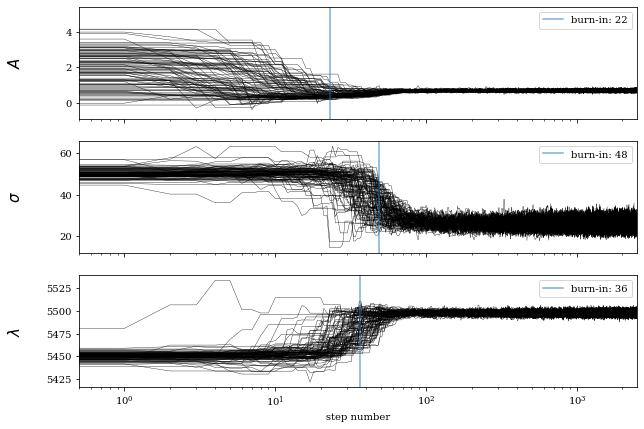

In [123]:
fig, axes = plt.subplots(3, figsize = (10,7), sharex = True)
samples = sampler.get_chain()
labels = ["$A$", r"$\sigma$", r"$\lambda$"]

axes[-1].set_xlabel("step number");
tau = sampler.get_autocorr_time()
print("AUTO CORRELATION TIMES:")
print(tau)

for i in range(ndim):
    ax = axes[i]
    ax.semilogx(samples[:, :, i], "k", lw = 0.35)
    print(np.median(samples[:, :, i]))
    ax.set_xlim(0.5, len(samples))
    ax.set_ylabel(labels[i], size = 15)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.axvline(tau[i], label = "burn-in: " + str(int(tau[i])), alpha = 0.6)
    ax.legend()



Given that the chains burn-in, one can easily see the action of each chain in log-space as it converges on the likeliest value. You can see some of the less accurate paths at small step numbers, and how they eventually become part of the 'accepted' value that we find. 
Most interestingly, I found that using different prior estimates could lead to multi-chain degeneracies, and a longer burn-in (not shown). This highlights the importance of using a 'good' guess, especially if the maximum likelihood is spread over a relatively large region.

While the relevant plots are above, I find that the autocorrelation time varies per run (30-50 steps), but I automatically choose this as the burn-in/cut-off moving forward.

I've visualized each parameter below in a way that is slightly more intuitive, to help illustrate the accuracy of convergence. 

In [124]:
burn = int(np.max(tau))
print(burn)

flat_samples = sampler.get_chain(discard=burn, flat=True)
print(flat_samples.shape)

48
(245200, 3)


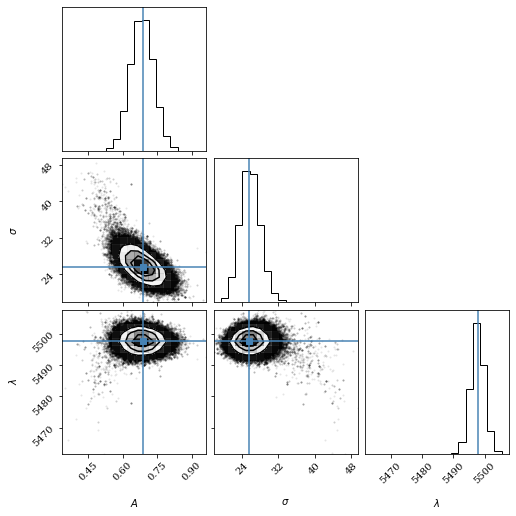

In [125]:
fig = corner.corner(flat_samples, labels=labels, truths=opt.x)

### Upper limits on linewidth

We can use the upper bound on the 68.7th, 95.5th, and 99.7th percentile ranges for sigma, to get a better sense of the bounds on our result.

In [142]:
samples = sampler.chain[:,50:,:].reshape((-1, ndim))
sortedvals = np.sort(samples[:,1])
for thresh in (0.683,0.954,0.997):
    nlimit = int(len(sortedvals)*thresh)
    print(thresh,sortedvals[nlimit])

0.683 26.85351505578636
0.954 29.803691145595536
0.997 33.75864631911633


### Recap: Which is better? Evaluating the likelihood space for an estimation, or using MCMC to converge on a solution
A mix of good and bad can be said for both methods: 

We can constrain parameters in a model space with both techniques, in a way that simple estimates cannot. However, using MCMC is a bit more robust as you have a very descriptive log of every process in your algorithm. You can make an incorrect guess and it will 'walk' to the right answer. In this sense it's quite hands-off when compared to a model grid, so long as you assemble your log-likelihood. 

With the model-grid you can manually evaluate whether your constrained parameters are reasonable, but with MCMC you are delegating the process to an automated algorithm. You also have to deal with additional compute time/resources. 

In comparison to the very first procedure, MCMC is way more robust and stable for finding our values. It takes more computational power, but atleast you can use one of the values from the first method to inform the starting position of your walkers in MCMC.